In [195]:
import sqlite3
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt

In [52]:
def show_tables():
    '''
    display all tables currently in database
    '''
    return pd.read_sql_query('''
    SELECT 
        name as tables_in_database  
    FROM 
        sqlite_master 
    WHERE 
        type ='table' AND 
        name NOT LIKE 'sqlite_%';''', conn)

def sql(query, **kwargs):
    try: 
        return pd.read_sql_query(query, conn, **kwargs)
    except TypeError:
        print('Table Created/Dropped')

def df_to_sql(table_name, dataframe, **kwargs):
    dataframe.to_sql(table_name, conn, index=False, **kwargs)
    
conn = sqlite3.connect('fb_test.db')

In [487]:
'''
cursor=conn.cursor()  
dropTableStatement = "DROP TABLE payment2"
cursor.execute(dropTableStatement)
show_tables()
'''

'\ncursor=conn.cursor()  \ndropTableStatement = "DROP TABLE payment2"\ncursor.execute(dropTableStatement)\nshow_tables()\n'

In [54]:
print(show_tables())

seat = sql(query="select * from seat")  
user = sql(query="select * from user")  
game = sql(query='''select * from game''')  
payment = sql(query="select * from payment")    

#seat, user, game, payment
print(len(seat.index)) 
print(len(game.index))
print(len(user.index))
print(len(payment.index))  

print(seat['seat_id'].nunique()==len(seat.index)) #seat table primary key: 'seat_id'
print(game['game_id'].nunique()==len(game.index)) #game table primary key: 'game_id'
print(user['user_id'].nunique()==len(user.index)) #user table primary key: 'user_id'
print(payment['payment_id'].nunique()==len(payment.index)) #payment table primary key: 'payment_id'

  tables_in_database
0               seat
1               user
2               game
3            payment
6620
1138
987
393
True
True
True
True


In [55]:
seat.head(3)

,user_id,game_id,seat_id,entry_fee,ticket,winnings
0,d73836ac4714d84d6ce28aa8ae0a5f0408d6dca4,7b0d2c19d0a90ce62cb4e66ada096beedbb454fb,be4783261874cbe4321f831ad1e9b7ce017f41ce,0.0,0,0.0
1,e7d8e5c99aab5671edf2c30a27d360295831b892,7b0d2c19d0a90ce62cb4e66ada096beedbb454fb,d82320fd311de63fc67357d875362c405db8d20d,0.0,0,0.0
2,9da633d5506f9807e576771ae9928081cc73cad7,7e20f0577b680fc3c524d910da9c8b6ec662d119,8edfdc71753de61dbc9e170fca7017aeb5ba0176,0.0,0,0.0


In [56]:
user.head(3)

,user_id,reg_date,last_login
0,8a8de0ae37eeddafd21162905c64a5a957e64a56,2018-01-01,2018-01-01 08:05:07
1,a949779b8972c29d9ef9ed209e7ffa8ea6e110bb,2018-02-04,2018-02-05 17:03:11
2,e4a3663706fd6fe113e6552e72160bdc9246a99c,2018-03-22,1970-01-01 00:00:00


In [57]:
game.head(3)

,game_id,game_date,sport
0,e15f65305fa7e97619a1c16c6335687eccbdd9c3,2018-01-06 13:35:00,NFL
1,aec411d81a2d1a34473dafe4eb5d584e6376fd42,2018-01-07 10:05:00,NFL
2,224a382faf74e813df517295eb949e37e4472109,2018-01-03 16:00:00,NBA


In [22]:
payment.head(3)

,user_id,payment_date,amount,payment_id
0,1d2d7a371d363338b740b9d6f30d3133e7bab399,2018-10-10 15:53:58,10.0,321b5be4b568219e86f87509cb3a4f9f1a4bc93f
1,f62281116a4c3f3943fd93cd3b9398581eb86aa3,2019-01-11 15:12:09,25.0,3df68d061fd401d270e0f5e1da20126223872677
2,178e16fb114a540bc3c5ea62c2827b411af4366b,2018-10-06 10:38:19,100.0,507b23306beceaaa6100f8dcf5bb464607662b06


In [58]:
####Question 1;       
#note: entry_date is not well-defined and found in problem set, use "game_date" here as a substitute. 
#Payment table has 235 unique user_ids, seat table with 490 user_ids, and user table with 987 user_ids;  
#Due to this systmatic missing issue (not imputable on user-level), "inner join" is adopted linking all database.  

#(1) process payment data;         
payment2 = sql(query='''      
           select user_id, min(pay_date) as first_deposit_date, max(pay_date) as last_deposit_date, 
           count(distinct payment_id) as number_of_deposits, 
           sum(amount) as total_deposit_amt
           from 
           (  
           select *,    
           SUBSTR(payment_date, 1, 10) as pay_date      
           from payment
           )
           group by user_id
           ''')      
df_to_sql('payment2', payment2)


#(2) add game info to seat data; 
seat_game = sql(query='''
           select a.*, SUBSTR(b.game_date, 1, 10) as entry_date, b.sport  
           from seat a
           inner join  
           game b  
           on a.game_id=b.game_id
            ''')
df_to_sql('seat_game', seat_game)    

In [71]:
#(3) combine 3 data (user, seat_game, payment2) together;       
comb=sql(query='''  
        select a.user_id, a.reg_date, b.sport, b.seat_id, b.game_id, b.entry_date, b.entry_fee, b.ticket, b.winnings, 
        c.first_deposit_date, c.last_deposit_date, c.number_of_deposits, c.total_deposit_amt
        from    
        user a
        inner join  
        seat_game b  
        on a.user_id=b.user_id   
        inner join   
        payment2 c
        on a.user_id=c.user_id    
        ''')     

In [72]:
####Question 2:  
#Due to incomplete data collected in 2019 (11-month), this exploratory analysis will focus on 2018's data. 
#Add date features; 
comb['game_year']=comb['entry_date'].apply(lambda x: int(x.split('-')[0]))
comb['game_qtr']=comb['entry_date'].apply(lambda x: (int(x.split('-')[1])-1)//3+1)      
comb['game_mon']=comb['entry_date'].apply(lambda x: int(x.split('-')[1]))

comb['reg_year']=comb['reg_date'].apply(lambda x: int(x.split('-')[0]))
comb['reg_qtr']=comb['reg_date'].apply(lambda x: (int(x.split('-')[1])-1)//3+1)    
comb['reg_mon']=comb['reg_date'].apply(lambda x: int(x.split('-')[1]))

#Subset to 2018;   
# comb2018=comb.loc[comb['game_year']==2018, :]
# comb2018.head()

In [66]:
import matplotlib as plt
%matplotlib inline   
import seaborn as sns
#plt.show()

#set the background style, plot size, xlab, ylab, title, 

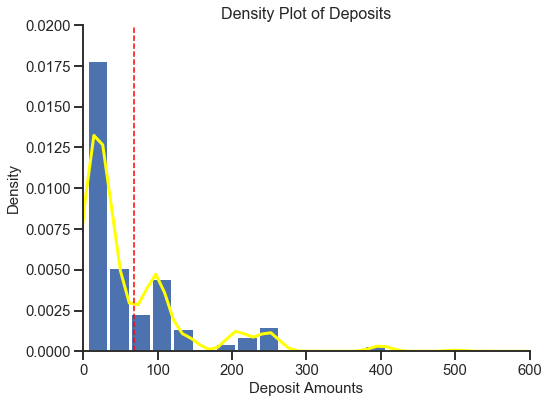

In [396]:
#(1) 1 var (continuous);    
#sns.set()
sns.set_style('ticks')
sns.set_context(context="talk", font_scale=0.9)
plt.figure(figsize=(8, 6))

sns.distplot(comb["total_deposit_amt"], kde=True, color='y', 
             kde_kws={"color": "yellow", "lw": 3, "label": ""},
             hist_kws={"linewidth": 3, "alpha": 1, "color": "b"})
sns.despine()  

plt.title('Density Plot of Deposits', fontsize=16)
plt.xlabel('Deposit Amounts', fontsize=15)  
plt.ylabel('Density', fontsize=15)
plt.ylim(0, 0.02)  
plt.xlim(0, 600)    

plt.axvline(comb["total_deposit_amt"].mean(), color="red", linestyle="--", linewidth=1.5)

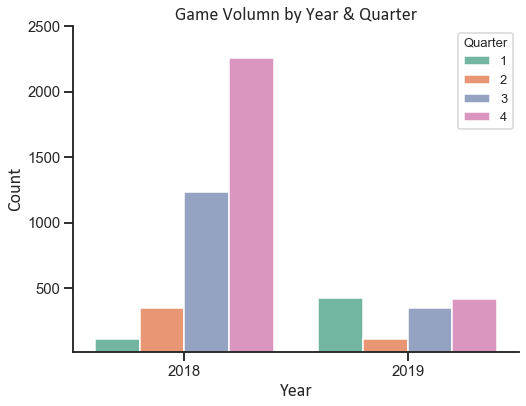

In [429]:
#1 or 2 var (discrete);   
sns.set_style('ticks')
sns.set_context(context="talk", font_scale=0.9)
plt.figure(figsize=(8, 6))

sns.countplot(x="game_year", data=comb, hue="game_qtr", palette="Set2")
sns.despine()    
 
plt.title('Game Volumn by Year & Quarter', fontsize=18, fontname="Calibri")  
plt.xlabel('Year', fontsize=18, fontname="Calibri")  
plt.ylabel('Count', fontsize=18, fontname="Calibri")    
plt.ylim(10, 2500)      
plt.legend(loc='upper right', prop={'size': 13}, title="Quarter", title_fontsize=13) #, frameon=False

#palette options: https://seaborn.pydata.org/tutorial/color_palettes.html  
#palette options: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

(-200, 1800)

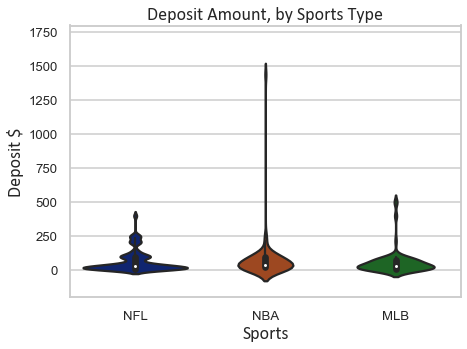

In [488]:
#x=categorical, y=continuous, hue=another categorical
sns.set_style("whitegrid")
sns.set_context(context="talk", font_scale=0.8)
plt.figure(figsize=(7, 5))

#sns.boxplot(x="sport", y="total_deposit_amt", data=comb, hue="ticket")
sns.violinplot(x="sport", y="total_deposit_amt", data=comb, palette="dark")

plt.title('Deposit Amount, by Sports Type', fontsize=18, fontname="Calibri")  
plt.xlabel('Sports', fontsize=18, fontname="Calibri")    
plt.ylabel('Deposit $', fontsize=18, fontname="Calibri")    
plt.ylim(-200, 1800)      

(0, 1000)

<Figure size 576x432 with 0 Axes>

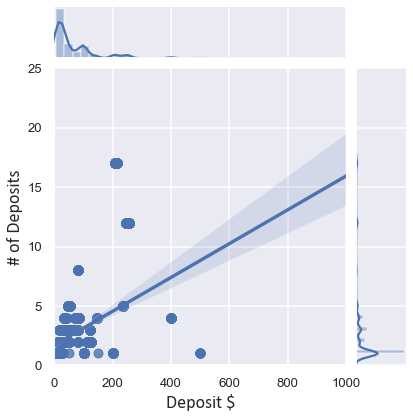

In [432]:
#(2) bivariate: continuous v.s. continuous;   
sns.set_style("darkgrid")    
sns.set_context(context="talk", font_scale=0.8)
plt.figure(figsize=(8, 6))

sns.jointplot(x='total_deposit_amt', y='number_of_deposits', data=comb, kind="reg") #marginal_kws={'color':'#99ffff'} 

plt.xlabel('Deposit $', fontsize=18, fontname="Calibri")    
plt.ylabel('# of Deposits', fontsize=18, fontname="Calibri")  
plt.ylim(0, 25)    
plt.xlim(0, 1000)      
#plt.legend(loc='upper right', prop={'size': 12}) #, frameon=False


(0, 100)

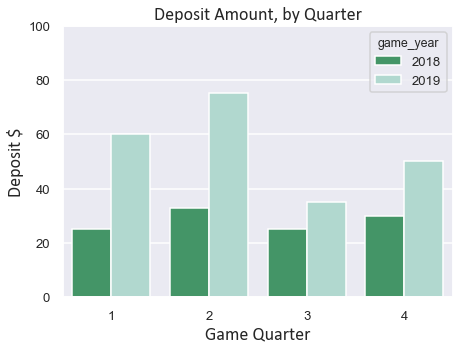

In [489]:
#continuous (y) v.s. discrete (x)
import numpy as np
sns.set_style("darkgrid")  
sns.set_context(context="talk", font_scale=0.8)
plt.figure(figsize=(7, 5))  
  
sns.barplot(y="total_deposit_amt", x="game_qtr", hue="game_year", data=comb, estimator=np.median, ci=None, 
            palette="BuGn_r")
# 
#estimator=np.sum, np.median, etc.  #           palette=[]"lightpink"

plt.title('Deposit Amount, by Quarter', fontsize=18, fontname="Calibri")  
plt.xlabel('Game Quarter', fontsize=18, fontname="Calibri")    
plt.ylabel('Deposit $', fontsize=18, fontname="Calibri")  
plt.ylim(0, 100)      

Text(0.5, 1.0, 'Density Distribution of Entry Fees')

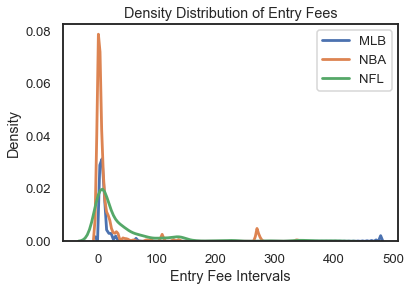

In [500]:
b=pd.DataFrame(comb2018.groupby('game_id')['entry_fee'].sum())
b['game_id']=b.index
b.reset_index(drop=True, inplace=True)  
c=comb2018.loc[:, ['sport', 'game_id']]
c.drop_duplicates(inplace=True)  
b=b.merge(c, on='game_id')    

import seaborn as sns  
sports = b['sport'].unique()
for s in sports:
    subset = b[b['sport'] == s]  
    sns.distplot(subset['entry_fee'], hist = False, kde = True,
                 kde_kws = {'linewidth': 2.8}, label = s, bins=50)   
plt.legend()
plt.xlabel('Entry Fee Intervals')   
plt.ylabel('Density')  
plt.title('Density Distribution of Entry Fees')          

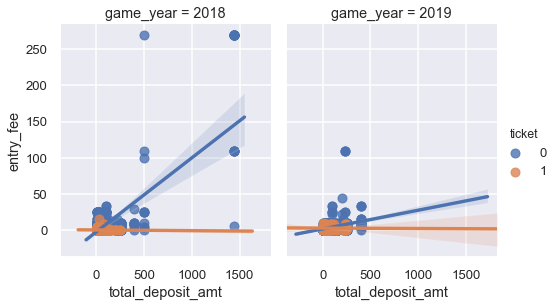

In [495]:
#regression plot;  
#2 ways to present: hue=, col=;  
sns.lmplot(data=comb, x="total_deposit_amt", y="entry_fee", col="game_year", hue="ticket", aspect=0.8, size=4.5) #row="game_qtr"  

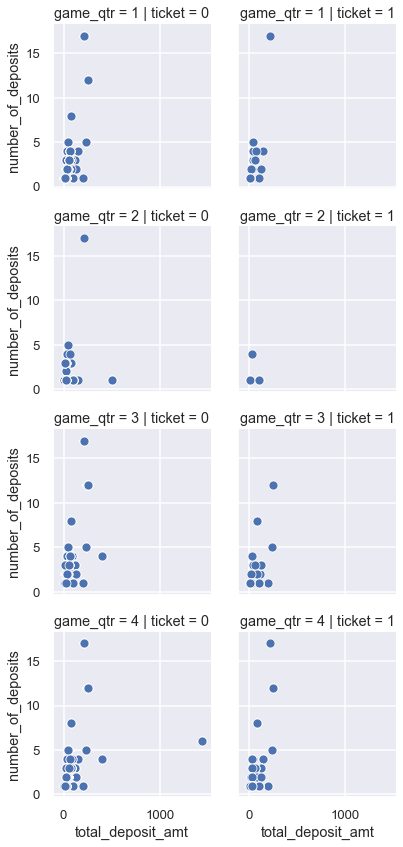

In [491]:
#Whatever plots over 2 categorical features;   
g=sns.FacetGrid(data=comb, col="ticket", row="game_qtr") #to set the 
# g.map(sns.distplot, "total_deposit_amt")
g.map(sns.scatterplot, "total_deposit_amt", "number_of_deposits")

<Figure size 576x576 with 0 Axes>

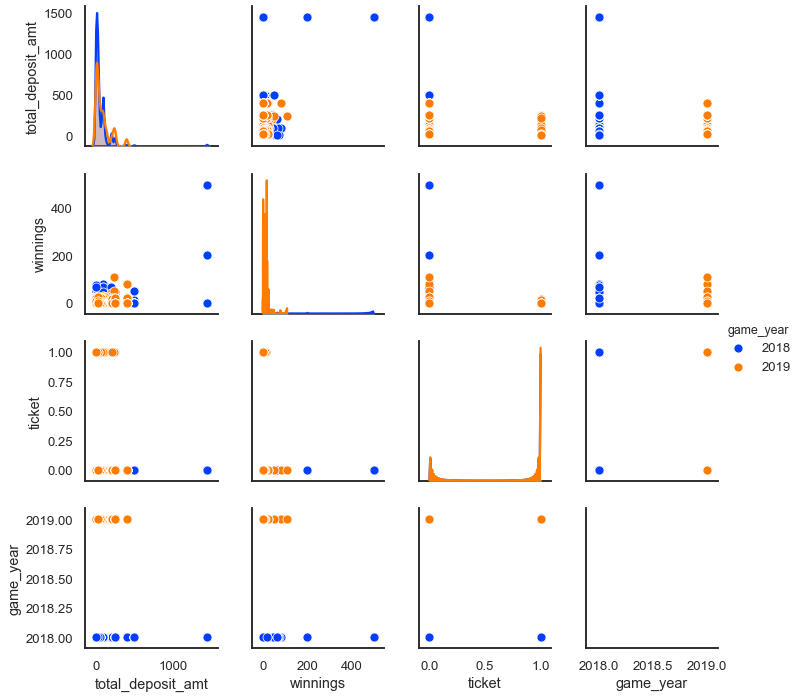

In [496]:
#a set of continuous, discrete features; 
sns.set_style("white")
sns.set_context(context="talk", font_scale=0.8)
plt.figure(figsize=(8, 8))  

sub=comb.loc[:, ['total_deposit_amt', 'winnings', 'ticket', 'game_year']]
sns.pairplot(sub, hue="game_year", palette="bright") #hue as categorical var to color;     

In [ ]:
'''
###A more generalized plot: factor plot
#sns.factorplot(x="sport", y="total_deposit_amt", data=comb, kind="bar") #reset the kind 
#x=categorical, y=continuous; 
#use both swarm & violin to see a data distribution roughly; 
#sns.violinplot(x="sport", y="total_deposit_amt", data=comb)
#sns.swarmplot(x="sport", y="total_deposit_amt", data=comb) #split=True, splits the hue colors!
'''

In [490]:
'''
##more customized pairgrid;   
sub2=comb.loc[:, ['entry_fee', 'winnings', 'number_of_deposits']]  
g=sns.PairGrid(sub2)
g.map_diag(sns.distplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
'''

"\n##more customized pairgrid;   \nsub2=comb.loc[:, ['entry_fee', 'winnings', 'number_of_deposits']]  \ng=sns.PairGrid(sub2)\ng.map_diag(sns.distplot)\ng.map_upper(sns.scatterplot)\ng.map_lower(sns.kdeplot)\n"

In [31]:
#(2-7) Given the missings, confirms the popularity of NFL and NBA;   
f=pd.DataFrame((comb2018.groupby(['sport', 'game_qtr'])['seat_id'].nunique())/(comb2018.groupby(['sport'])['seat_id'].count()),)
f.rename(columns={'seat_id': '% of annual seats'}, inplace=True)  
f.index = f.index.set_names(['sport', 'game quarter'])  
f  
f.style.format({'% of annual seats': '{:,.2%}'.format,})                    
'''
The 2018 data doesn't have data for 3rd quarter NBA, and 2nd quarter NFL;    
Given the data, 3rd quarter is the popular time for MLB, and 4th quarter for NBA and NFL.   
The missing problem, re-confirms the popularity of NFL and NBA over MLB, which have larger user volumes 
given the missing data. 
'''

In [32]:
'''
#Summarize findings on Question 2;  
(1) The analysis of Question 2 focus on 2018 data for more completeness of data being collected (only 11-month in 
2019 yet). It was found that, the 3rd quarter data is not available for NBA and 2nd quarter not available for NFA. 
Given this data insufficiency, still, NFL and NBA got larger game volumes (see anlysis 2-1), and NFL's attracted 
more than half users of all 3 games (analysis 2-2).

(2) Average entry fees paid by NFL users on each game, is almost doubled of NBA users. MLB users paid the least 
(see graph 2-3). Entry fees paid by NFL users most ranges between 0 to $150, while the majority of NBA users 
paid entry fees around 0 to $30 (see graph 2-4).

(3) The % ticket use of 3 games doesn't vary much, around 4%, with NFL slightly more than 5% (see graph 2-5).
NBA users win the most at $5 per seat, two times of more than NFL and MLB.     

To conclude, NFL is the most popular sport in terms of user volume. Users are willing to bet more on NFL, 
which is not incentivized by coupons/winning dollars, but likely more driven by the passion over the sport. 
'''

"\n#Summary of findings on Question 2; \n(1) The analysis of Question 2 focus on 2018 data for more completeness of data being collected (only 11-month in \n2019 yet). It was found that, the 3rd quarter data is not available for NBA and 2nd quarter not available for NFA. \nGiven this data insufficiency, still, NFL and NBA got larger game volumes (see anlysis 2-1), and NFL's attracted \nmore than half users of all 3 games (analysis 2-2).\n\n(2) Average entry fees paid by NFL users on each game, is almost doubled of NBA users. MLB users paid the least \n(see graph 2-3). Entry fees paid by NFL users most ranges between 0 to $150, while the majority of NBA users \npaid entry fees around 0 to $30 (see graph 2-4).\n\n(3) The % ticket use of 3 games doesn't vary much, around 4%, with NFL slightly more than 5% (see graph 2-5).\nNBA users win the most at $5 per seat, two times of more than NFL and MLB.     \n\nTo conclude, NFL is the most popular sport in terms of user volume. Users are willing

In [33]:
####Question 3;       
#one-hot encoding for seat-level data; 
def prepcate(df):        
    scat=['sport', 'reg_qtr', 'game_qtr']             
    for i in scat:    
        df[i]=df[i].apply(lambda x: str(x))    
        for j in df[i].unique():      
            df[i+'_'+str(j)]=np.where(df[i]==j, 1, 0)
        df.drop(i, axis=1, inplace=True)              
    return df      
comb=prepcate(comb)  

In [34]:
#aggregate features upto user level;   

#part 1: add number of seats, number of games for each user; 
p1=comb.groupby('user_id')['seat_id', 'game_id'].nunique()     
p1.rename(columns={'seat_id': 'num_seats', 'game_id': "num_games"}, inplace=True)  


#part 2: sum up entry fees (Label column), tickets, winnings, deposits, deposit amonts, NFL/NBA/MLB gaming times
p2=comb.groupby('user_id')['entry_fee', 'ticket', 'winnings', 'number_of_deposits', 'total_deposit_amt',
                           'sport_NFL', 'sport_NBA', 'sport_MLB'].sum()    
p2.rename(columns={'entry_fee': 'sum_entry_fee', 'ticket': "sum_ticket", 'winnings': "sum_winnings", 
                   "number_of_deposits": "sum_deposits", "total_deposit_amt": "sum_deposit_amts",     
                   "sport_NFL": "sum_NFL", "sport_NBA": "sum_NBA", "sport_MLB": "sum_MLB"}, inplace=True)  


#part 3: one-hot encoding for registration quarter, gaming quarter, and sport type; 
_p3=comb.loc[:, ["user_id", "reg_qtr_1", "reg_qtr_2", "reg_qtr_3", "reg_qtr_4", "game_qtr_1", "game_qtr_2", "game_qtr_3", 
                "game_qtr_4", "sport_NFL", "sport_NBA", "sport_MLB"]] 
p3=_p3.groupby('user_id')["reg_qtr_1", "reg_qtr_2", "reg_qtr_3", "reg_qtr_4", "game_qtr_1", "game_qtr_2", 
                         "game_qtr_3", "game_qtr_4", "sport_NFL", "sport_NBA", "sport_MLB"].max()

#part 4: sum up numbers the rest of features; 
p4=_p3.groupby('user_id')["reg_qtr_1", "reg_qtr_2", "reg_qtr_3", "reg_qtr_4", "game_qtr_1", "game_qtr_2", 
                         "game_qtr_3", "game_qtr_4", "sport_NFL", "sport_NBA", "sport_MLB"].sum()  
p4.rename(columns={"reg_qtr_1": "sum_reg_qtr_1", "reg_qtr_2": "sum_reg_qtr_2", "reg_qtr_3": "sum_reg_qtr_3",
                   "reg_qtr_4": "sum_reg_qtr_4", "game_qtr_1": "sum_game_qtr_1", "game_qtr_2": "sum_game_qtr_2", 
                   "game_qtr_3": "sum_game_qtr_3", "game_qtr_4": "sum_game_qtr_4", "sport_NFL": "sum_sport_NFL", 
                   "sport_NBA": "sum_sport_NBA", "sport_MLB": "sum_sport_MLB"}, inplace=True)      

#combine 4 parts of data together;    
combfull=p1.merge(p2, on="user_id")  
combfull=combfull.merge(p3, on="user_id")    
combfull=combfull.merge(p4, on="user_id")        

In [64]:
print("number of rows:", len(combfull))
print("number of columns:", len(combfull.columns))

number of rows: 224
number of columns: 32


In [56]:
#Due to very small data available (224 observations), here we use cross-validation to evaluate model's performance;
#Due to this limited degree of freedom, we also tuned learning rate to be small, and max_depth to limit each tree's complexity; 
import lightgbm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split        
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score    
from sklearn.model_selection import KFold  

X=combfull.drop('sum_entry_fee', axis=1)  
Y=combfull['sum_entry_fee']
kf = KFold(n_splits=5, random_state=12345, shuffle=False)
kf.get_n_splits(X)  

ytest_pred=[]
for train_index, test_index in kf.split(X):
    #Prepare dataset; 
    xtrain, xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = Y.iloc[train_index], Y.iloc[test_index]

    d_train = lightgbm.Dataset(xtrain, label=ytrain)
    d_test = lightgbm.Dataset(xtest, label=ytest)
    watchlist = [d_train, d_test]
    
    #Lightgbm Regressor; 
    params = {'boosting_type': 'gbdt',
          'objective': 'regression',  
          'metric': 'rmse',  
          'max_depth': 5, 
          'learning_rate': 0.0001,    
          'early_stopping_round': 200}
    
    n_estimators = 100000      
    model = lightgbm.train(params=params, train_set=d_train, num_boost_round=n_estimators, valid_sets=watchlist, verbose_eval=1000)
    
    ytest_pred.append(model.predict(xtest))

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 256.62	valid_1's rmse: 104.538
[2000]	training's rmse: 250.476	valid_1's rmse: 97.0756
[3000]	training's rmse: 245.176	valid_1's rmse: 90.48
[4000]	training's rmse: 240.613	valid_1's rmse: 84.8315
[5000]	training's rmse: 236.693	valid_1's rmse: 79.9922
[6000]	training's rmse: 233.312	valid_1's rmse: 76.0795
[7000]	training's rmse: 230.403	valid_1's rmse: 72.9347
[8000]	training's rmse: 227.911	valid_1's rmse: 70.4029
[9000]	training's rmse: 225.772	valid_1's rmse: 68.7265
[10000]	training's rmse: 223.903	valid_1's rmse: 67.8616
[11000]	training's rmse: 222.257	valid_1's rmse: 67.3987
[12000]	training's rmse: 220.804	valid_1's rmse: 67.1902
[13000]	training's rmse: 219.518	valid_1's rmse: 67.131
Early stopping, best iteration is:
[12876]	training's rmse: 219.67	valid_1's rmse: 67.1272
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 109.877	valid_1's rmse: 480.571
[

In [59]:
#Performance evaluation;
#Although this is a Regression problem, we still consier <=10 dollar difference of prediction and ground truth 
#as "accurate prediction" to help evaluate the performance (more concrete than just based on RMSE).
ypred_list=[]
for i in ytest_pred:
    for j in i:
        ypred_list.append(j)
        

from sklearn.metrics import mean_squared_error, r2_score
y_preddummy=(abs(ypred_list-Y)<=10)  

RSME=np.sqrt(mean_squared_error(Y, ypred_list))   
R2=r2_score(Y, ypred_list)
Accu=y_preddummy.value_counts()/len(y_preddummy)

data = [RSME, R2, Accu[True]]  
performance_metric = pd.DataFrame(data, index=['RSME', 'R-squared', 'Accuracy'], columns=['Value']) #smaller, bigger, bigger; 
pd.DataFrame(performance_metric).to_csv('performance_metric.txt', sep='\t', header=True, index=True)

print(performance_metric)
pd.DataFrame(ypred_list).to_csv('y_pred.txt', sep='\t', header=False, index=True)

'''
As expected, the overall performance of the model is not satisfactory, it's mainly becuase of the ground 
truth data is too small!
'''  

                Value
RSME       204.377164
R-squared    0.281593
Accuracy     0.191964
